In [1]:
from langchain.agents.agent_types import AgentType
from langchain.chat_models import ChatOpenAI
import pandas as pd
from langchain.llms import OpenAI
import os
import pandas as pd

In [ ]:
# Feed JSON data to the agent
from langchain.document_loaders import DirectoryLoader, TextLoader, CSVLoader
from langchain_community.document_loaders import PyPDFLoader

#loader = DirectoryLoader('F1_Data', glob='**/*.json', show_progress=True, loader_cls=TextLoader)
loader_csv = DirectoryLoader('FinalData', show_progress=True, use_multithreading=True, loader_cls=CSVLoader, glob='**/*.csv')

csv_docs = loader_csv.load()
# loader for pdf
#loader = DirectoryLoader('F1_Data', glob='**/*.pdf', show_progress=True, loader_cls=PDFLoader)

#docs = loader.load()
#print(len(docs))

from langchain.indexes import VectorstoreIndexCreator
#index = VectorstoreIndexCreator().from_loaders([loader_csv, loader_pdf])



In [2]:
from langchain_experimental.agents.agent_toolkits import create_python_agent
from langchain.agents import load_tools, initialize_agent
from langchain.agents import AgentType
from langchain_experimental.tools.python.tool import PythonREPLTool
from langchain.python import PythonREPL
from langchain.chat_models import ChatOpenAI
from util import local_settings
# !pip install wikipedia
model="gpt-3.5-turbo"
from langchain.document_loaders import DirectoryLoader, TextLoader, CSVLoader
from langchain_community.document_loaders import PyPDFLoader



sk-LCAqduOz4rTSH8NhaGGhT3Bl


In [3]:
import os
import pandas as pd
from PyPDF2 import PdfReader
from langchain.text_splitter import CharacterTextSplitter
import re
import numpy as np
from langchain_community.document_loaders import PyPDFLoader
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings


def preprocess_pdf_files_for_LLM(path: str):
    pdf_docs = []
    for file in os.listdir(path):
        if file.endswith(".pdf"):
            pdf_docs.append(os.path.join(path, file))
    text = ""
    for pdf in pdf_docs:
        pdf_reader = PdfReader(pdf)
        for page in pdf_reader.pages:
            text += page.extract_text()
    text_splitter = CharacterTextSplitter(
        separator="\n",
        chunk_size=1000,
        chunk_overlap=200,
        length_function=len
    )
    chunks = text_splitter.split_text(text)

    embeddings = OpenAIEmbeddings()
    # embeddings = HuggingFaceInstructEmbeddings(model_name="hkunlp/instructor-xl")
    vectorstore = FAISS.from_texts(texts=chunks, embedding=embeddings)
    return vectorstore

def preprocess_csv_files_for_LLM(path: str):
    csv_docs = []
    for file in os.listdir(path):
        if file.endswith(".csv"):
            csv_docs.append(os.path.join(path, file))
    text = ""
    for csv in csv_docs:
        df = pd.read_csv(csv)
        for col in df.columns:
            text += col + "\n"
            for row in df[col]:
                text += str(row) + "\n"
    text_splitter = CharacterTextSplitter(
        separator="\n",
        chunk_size=1000,
        chunk_overlap=200,
        length_function=len
    )
    chunks = text_splitter.split_text(text)

    embeddings = OpenAIEmbeddings()
    # embeddings = HuggingFaceInstructEmbeddings(model_name="hkunlp/instructor-xl")
    vectorstore = FAISS.from_texts(texts=chunks, embedding=embeddings)
    return vectorstore

#pdf_files = preprocess_pdf_files_for_LLM("FinalData\\Articles\\")
#csv_files = preprocess_csv_files_for_LLM("FinalData\\")

In [4]:
pdf_files = preprocess_pdf_files_for_LLM("FinalData\\Articles\\")

In [15]:
csv_files = preprocess_csv_files_for_LLM("FinalData\\A.FantasyF1_2023\\")

In [17]:
csv_files2 = preprocess_csv_files_for_LLM("FinalData\\F1_Data\\")

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for text-embedding-ada-002 in organization org-xThP8bDChYedB4a2IVODMlAy on tokens per min (TPM): Limit 1000000, Used 337802, Requested 685334. Please try again in 1.388s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}

In [ ]:
# Create a function that will be used as as tool that interacts with the Ergast API to gather data on Formula 1
def get_data_from_ergast_api(year: int):
    import requests
    import json
    url = f"https://ergast.com/api/f1/{year}/driverStandings.json"
    response = requests.get(url)
    data = json.loads(response.text)
    return data

In [ ]:
def gather_data_from_fastf1()

In [3]:
import fastf1 as ff1
from fastf1 import plotting
from fastf1 import utils
import fastf1.legacy
import fastf1 as ff1
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm
import matplotlib.font_manager as fm
import numpy as np
import pandas as pd
import matplotlib as mpl
colormap = mpl.cm.plasma

def draw_f1_circuit(circuit, year = 2023):
    session = fastf1.get_session(year, circuit, 'R')
    session.load()
    circuit_info = session.get_circuit_info()
    lap = session.laps.pick_fastest()
    pos = lap.get_pos_data()
    fig, ax = plt.subplots(figsize=(10,5))

    track = pos.loc[:, ('X', 'Y')].to_numpy()

    track_angle = circuit_info.rotation / 180 * np.pi
    
    offset_vector = [500, 0]

    def rotate(xy, *, angle):
        rot_mat = np.array([[np.cos(angle), np.sin(angle)],
                            [-np.sin(angle), np.cos(angle)]])
        return np.matmul(xy, rot_mat)

    rotated_track = rotate(track, angle=track_angle)
    plt.plot(rotated_track[:, 0], rotated_track[:, 1], color ='tab:orange')
    
    # Iterate over all corners.
    for _, corner in circuit_info.corners.iterrows():
        # Create a string from corner number and letter
        txt = f"{corner['Number']}{corner['Letter']}"
    
        # Convert the angle from degrees to radian.
        offset_angle = corner['Angle'] / 180 * np.pi
    
        # Rotate the offset vector so that it points sideways from the track.
        offset_x, offset_y = rotate(offset_vector, angle=offset_angle)
    
        # Add the offset to the position of the corner
        text_x = corner['X'] + offset_x
        text_y = corner['Y'] + offset_y
    
        # Rotate the text position equivalently to the rest of the track map
        text_x, text_y = rotate([text_x, text_y], angle=track_angle)
    
        # Rotate the center of the corner equivalently to the rest of the track map
        track_x, track_y = rotate([corner['X'], corner['Y']], angle=track_angle)
    
        # Draw a circle next to the track.
        plt.scatter(text_x, text_y, color= 'yellow', s=140)
    
        # Draw a line from the track to this circle.
        plt.plot([track_x, text_x], [track_y, text_y], color= 'yellow')
    
        # Finally, print the corner number inside the circle.
        plt.text(text_x, text_y, txt,
                 va='center_baseline', ha='center', size='small', color=  'black')
        
        # Add title with session name
        plt.title(session.event['EventName'])
        
        # hide axis
        ax.axis('off')
        
        
    

In [63]:
session_event = ff1.get_session(2022, 'Bahrain', 'Q')
#session_event.load()

In [69]:
session_event.results

,DriverNumber,BroadcastName,Abbreviation,DriverId,TeamName,TeamColor,TeamId,FirstName,LastName,FullName,...,CountryCode,Position,ClassifiedPosition,GridPosition,Q1,Q2,Q3,Time,Status,Points
16,16,C LECLERC,LEC,leclerc,Ferrari,ed1c24,ferrari,Charles,Leclerc,Charles Leclerc,...,,1.0,,NaN,0 days 00:01:31.471000,0 days 00:01:30.932000,0 days 00:01:30.558000,NaT,,NaN
1,1,M VERSTAPPEN,VER,max_verstappen,Red Bull Racing,1e5bc6,red_bull,Max,Verstappen,Max Verstappen,...,,2.0,,NaN,0 days 00:01:31.785000,0 days 00:01:30.757000,0 days 00:01:30.681000,NaT,,NaN
55,55,C SAINZ,SAI,sainz,Ferrari,ed1c24,ferrari,Carlos,Sainz,Carlos Sainz,...,,3.0,,NaN,0 days 00:01:31.567000,0 days 00:01:30.787000,0 days 00:01:30.687000,NaT,,NaN
11,11,S PEREZ,PER,perez,Red Bull Racing,1e5bc6,red_bull,Sergio,Perez,Sergio Perez,...,,4.0,,NaN,0 days 00:01:32.311000,0 days 00:01:31.008000,0 days 00:01:30.921000,NaT,,NaN
44,44,L HAMILTON,HAM,hamilton,Mercedes,6cd3bf,mercedes,Lewis,Hamilton,Lewis Hamilton,...,,5.0,,NaN,0 days 00:01:32.285000,0 days 00:01:31.048000,0 days 00:01:31.238000,NaT,,NaN
77,77,V BOTTAS,BOT,bottas,Alfa Romeo,b12039,alfa,Valtteri,Bottas,Valtteri Bottas,...,,6.0,,NaN,0 days 00:01:31.919000,0 days 00:01:31.717000,0 days 00:01:31.560000,NaT,,NaN
20,20,K MAGNUSSEN,MAG,kevin_magnussen,Haas F1 Team,b6babd,haas,Kevin,Magnussen,Kevin Magnussen,...,,7.0,,NaN,0 days 00:01:31.955000,0 days 00:01:31.461000,0 days 00:01:31.808000,NaT,,NaN
14,14,F ALONSO,ALO,alonso,Alpine,2293d1,alpine,Fernando,Alonso,Fernando Alonso,...,,8.0,,NaN,0 days 00:01:32.346000,0 days 00:01:31.621000,0 days 00:01:32.195000,NaT,,NaN
63,63,G RUSSELL,RUS,russell,Mercedes,6cd3bf,mercedes,George,Russell,George Russell,...,,9.0,,NaN,0 days 00:01:32.269000,0 days 00:01:31.252000,0 days 00:01:32.216000,NaT,,NaN
10,10,P GASLY,GAS,gasly,AlphaTauri,4e7c9b,alphatauri,Pierre,Gasly,Pierre Gasly,...,,10.0,,NaN,0 days 00:01:32.096000,0 days 00:01:31.635000,0 days 00:01:32.338000,NaT,,NaN


In [66]:
session_event.load()#.laps.pick_driver('Leclerc').pick_fastest().get_telemetry().add_distance()

core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v3.1.6]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '1', '55', '11', '44', '77', '20', '14', '63', '10', '31', '47', '4', '23', '24', '22', '27', '3', '18', '6']


In [77]:
# Get driver abbreviation from their surname using session_event.results dataframe.
# We can find the row with their surname in LastName and store the corresponding value in Abbreviation.
Abbreviation = session_event.results[session_event.results['LastName'] == 'Leclerc']['Abbreviation'].values[0]
Abbreviation

'LEC'

In [84]:
session_event = ff1.get_session(2022, 'Bahrain', 'Q')
session_event.load()

driver01 = session_event.results[session_event.results['LastName'] == 'Verstappen']['Abbreviation'].values[0]
driver02 = session_event.results[session_event.results['LastName'] == 'Leclerc']['Abbreviation'].values[0]

drivers = [driver01, driver02]
compare_drivers = session_event.laps[session_event.laps['Driver'].isin(drivers)]

fastest_lap_driver01 = session_event.laps.pick_driver(driver01).pick_fastest()
fastest_lap_driver02 = session_event.laps.pick_driver(driver02).pick_fastest()

telemetry_driver01 = fastest_lap_driver01.get_telemetry().add_distance()
telemetry_driver02 = fastest_lap_driver02.get_telemetry().add_distance()

telemetry_driver01['Driver'] = driver01
telemetry_driver02['Driver'] = driver02

core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v3.1.6]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '1', '55', '11', '44', '77', '20', '14', '63', '10', '31', '47', '4', '23', '24', '22', '27', '3', '18', '6']


In [86]:
telemetry_driver02

,Date,SessionTime,DriverAhead,DistanceToDriverAhead,Time,RPM,Speed,nGear,Throttle,Brake,DRS,Source,RelativeDistance,Status,X,Y,Z,Distance,Driver
2,2022-03-19 15:58:18.339,0 days 01:13:17.410000,,591.047778,0 days 00:00:00,10514,292,7,100,False,12,interpolation,0.000006,OnTrack,-380,1280,-159,0.000000,LEC
3,2022-03-19 15:58:18.423,0 days 01:13:17.494000,,591.047778,0 days 00:00:00.084000,10502,293,7,100,False,12,pos,0.001283,OnTrack,-377,1350,-159,6.836667,LEC
4,2022-03-19 15:58:18.491,0 days 01:13:17.562000,,591.047778,0 days 00:00:00.152000,10478,294,8,100,False,12,car,0.002319,OnTrack,-373,1413,-158,12.390000,LEC
5,2022-03-19 15:58:18.723,0 days 01:13:17.794000,,591.047778,0 days 00:00:00.384000,10519,295,8,100,False,12,pos,0.005868,OnTrack,-362,1661,-158,31.401111,LEC
6,2022-03-19 15:58:18.731,0 days 01:13:17.802000,77,591.047778,0 days 00:00:00.392000,10560,296,8,100,False,12,car,0.005991,OnTrack,-361,1669,-157,32.058889,LEC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,2022-03-19 15:59:48.503,0 days 01:14:47.574000,77,465.962778,0 days 00:01:30.164000,11636,288,7,100,False,12,pos,0.991791,OnTrack,-396,961,-159,5329.548333,LEC
695,2022-03-19 15:59:48.611,0 days 01:14:47.682000,77,464.673889,0 days 00:01:30.272000,11495,289,7,100,False,12,car,0.993405,OnTrack,-391,1045,-159,5338.218333,LEC
696,2022-03-19 15:59:48.683,0 days 01:14:47.754000,77,462.607222,0 days 00:01:30.344000,11064,289,7,100,False,12,pos,0.994483,OnTrack,-389,1106,-159,5343.998333,LEC
697,2022-03-19 15:59:48.851,0 days 01:14:47.922000,77,460.540556,0 days 00:01:30.512000,10634,290,7,100,False,12,car,0.997002,OnTrack,-382,1242,-158,5357.531667,LEC


In [4]:
def compare_track_dominance(race_name, driver_surname1, driver_surname2, year = 2023, session = 'Q'):

    session_event = ff1.get_session(year, race_name, session)
    session_event.load()

    driver01 = session_event.results[session_event.results['LastName'] == driver_surname1]['Abbreviation'].values[0]
    driver02 = session_event.results[session_event.results['LastName'] == driver_surname2]['Abbreviation'].values[0]
    
    drivers = [driver01, driver02]
    compare_drivers = session_event.laps[session_event.laps['Driver'].isin(drivers)]
    
    fastest_lap_driver01 = session_event.laps.pick_driver(driver01).pick_fastest()
    fastest_lap_driver02 = session_event.laps.pick_driver(driver02).pick_fastest()
    
    telemetry_driver01 = fastest_lap_driver01.get_telemetry().add_distance()
    telemetry_driver02 = fastest_lap_driver02.get_telemetry().add_distance()
    
    telemetry_driver01['Driver'] = driver01
    telemetry_driver02['Driver'] = driver02
    #telemetry_drivers = pd.DataFrame(telemetry_driver01).append(pd.DataFrame(telemetry_driver02))
    telemetry_drivers = pd.concat([telemetry_driver01, telemetry_driver02])


    # We want 25 mini-sectors (this can be adjusted up and down)
    num_minisectors = 7*3
    
    # Grab the maximum value of distance that is known in the telemetry
    total_distance = total_distance = max(telemetry_drivers['Distance'])
    
    # Generate equally sized mini-sectors
    minisector_length = total_distance / num_minisectors
    
    
    # Initiate minisector variable, with 0 (meters) as a starting point.
    minisectors = [0]
    
    # Add multiples of minisector_length to the minisectors
    for i in range(0, (num_minisectors - 1)):
        minisectors.append(minisector_length * (i + 1))
    
    telemetry_drivers['Minisector'] = telemetry_drivers['Distance'].apply(
        lambda dist: (
            int((dist // minisector_length) + 1)
        )
    )
    
    average_speed = telemetry_drivers.groupby(['Minisector', 'Driver'])['Speed'].mean().reset_index()
    
    
    # Select the driver with the highest average speed
    fastest_driver = average_speed.loc[average_speed.groupby(['Minisector'])['Speed'].idxmax()]
    
    # Get rid of the speed column and rename the driver column
    fastest_driver = fastest_driver[['Minisector', 'Driver']].rename(columns={'Driver': 'Fastest_driver'})
        
    # Join the fastest driver per minisector with the full telemetry
    telemetry_drivers = telemetry_drivers.merge(fastest_driver, on=['Minisector'])
    
    # Order the data by distance to make matploblib does not get confused
    telemetry_drivers = telemetry_drivers.sort_values(by=['Distance'])
    
    # Convert driver name to integer
    telemetry_drivers.loc[telemetry_drivers['Fastest_driver'] == driver01, 'Fastest_driver_int'] = 1
    telemetry_drivers.loc[telemetry_drivers['Fastest_driver'] == driver02, 'Fastest_driver_int'] = 2
    
    x = np.array(telemetry_drivers['X'].values)
    y = np.array(telemetry_drivers['Y'].values)
    
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    fastest_driver_array = telemetry_drivers['Fastest_driver_int'].to_numpy().astype(float)
    
    cmap = plt.get_cmap('spring',2) 
    lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap)
    lc_comp.set_array(fastest_driver_array)
    lc_comp.set_linewidth(5)
    
    plt.rcParams['figure.figsize'] = [12, 6]
    
    plt.gca().add_collection(lc_comp)
    plt.axis('equal')
    plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
    
    cbar = plt.colorbar(mappable=lc_comp, label='Driver', boundaries=np.arange(1,4))
    cbar.set_ticks(np.arange(1.5, 3.5))
    cbar.set_ticklabels([driver01,driver02])
    # Store the fastest lap time of each driver. Use only minutes and seconds.
    
    title_color = 'silver' # '#6441a5'
    plt.title(f"{year} {race_name} | {session} {driver_surname1} ({fastest_lap_driver01['LapTime']}) vs {driver_surname2} ({fastest_lap_driver02['LapTime']})", color=title_color, fontsize = 16)

    
    plt.show()

core           INFO 	Loading data for Bahrain Grand Prix - Practice 3 [v3.1.6]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 22
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 22)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '10', '11', '14', '16', '18', '20', '22', '23', '24', '27', '3', '31', 

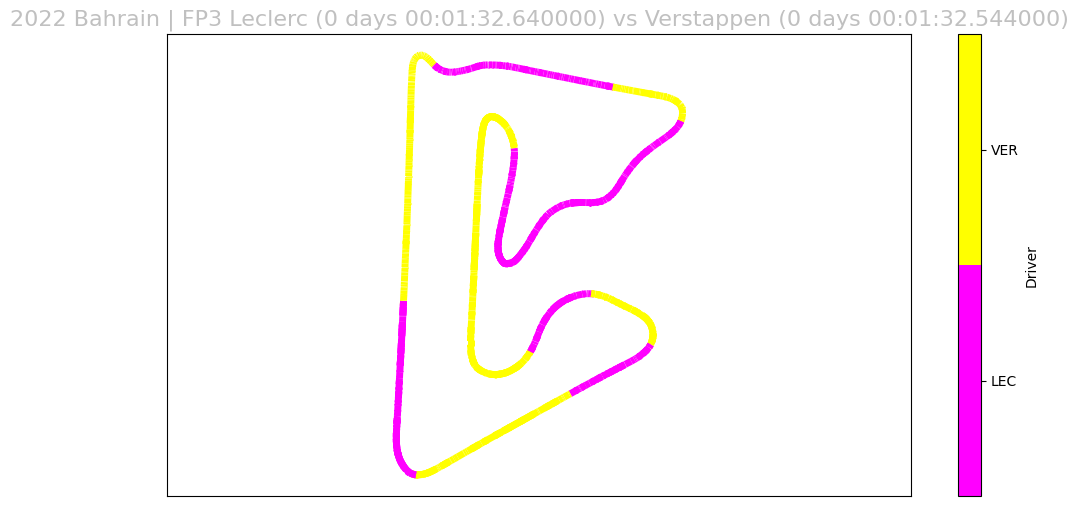

In [108]:
compare_track_dominance('Bahrain', 'Leclerc', 'Verstappen', year = 2022, session = 'FP3')

core           INFO 	Loading data for Portuguese Grand Prix - Race [v3.1.6]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '11', '4', '16', '31', '14', '3', '10', '55', '99', '5', '18', '22', '63', '47', '6', '9', '7']


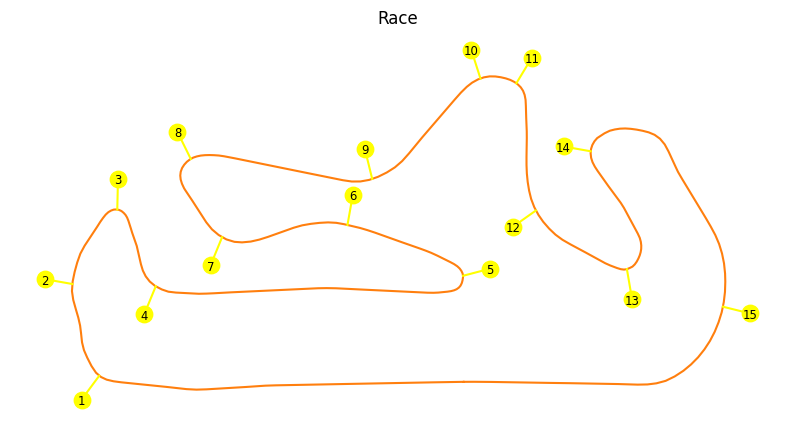

In [52]:
draw_f1_circuit('Portugal', 2021)

In [5]:
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI

chain = load_qa_chain(OpenAI(), chain_type="stuff")
prompt = f"Who won the 2023 Bahrain GP of Formula 1?"

docs =  pdf_files.similarity_search(prompt)
result = chain.run(input_documents=docs, question=prompt)
print(result)




The 2023 Bahrain Grand Prix was the opening round of the 2023 Formula One World Championship. It was held on 5 March 2023 at the Bahrain International Circuit in Sakhir, Bahrain.

Qualifying saw Max Verstappen of Red Bull Racing secure pole position with a time of 1:29.708, beating out Lewis Hamilton of Mercedes by 0.160 seconds. The race itself saw Verstappen maintain his lead, while Hamilton was overtaken by Sergio Pérez in the other Red Bull Racing car. Verstappen went on to win the race, securing his third World Drivers' Championship.

Pérez finished second, giving Red Bull Racing their first ever 1-2 finish in the World Drivers' Championship. Hamilton finished third, driving for Mercedes. Red Bull Racing also secured their sixth World Constructors' Championship, with Mercedes finishing second and Ferrari in third.

Several notable moments occurred during the race, including a thrilling final-lap battle between Fernando Alonso and Pérez for second place. Alonso, driving for Alpin

In [ ]:
# Feed JSON data to the agent
from langchain.document_loaders import DirectoryLoader, TextLoader, CSVLoader
from langchain_community.document_loaders import PyPDFLoader

#loader = DirectoryLoader('F1_Data', glob='**/*.json', show_progress=True, loader_cls=TextLoader)
loader_csv = DirectoryLoader('FinalData', show_progress=True, use_multithreading=True, loader_cls=CSVLoader, glob='**/*.csv')

csv_docs = loader_csv.load()
# loader for pdf
#loader = DirectoryLoader('F1_Data', glob='**/*.pdf', show_progress=True, loader_cls=PDFLoader)

#docs = loader.load()
#print(len(docs))

from langchain.indexes import VectorstoreIndexCreator
#index = VectorstoreIndexCreator().from_loaders([loader_csv])



In [ ]:
len(csv_docs)

In [5]:

OPENAI_API_KEY=local_settings.OPENAI_API_KEY

In [11]:
from langchain.pydantic_v1 import BaseModel, Field
from langchain.tools import BaseTool, StructuredTool, tool

llm = ChatOpenAI(temperature=0.1, model=model)
tools = load_tools(["llm-math","wikipedia", "ergast_retrieve"], llm=llm)
#tools += [
#    Tool(
#        name="State of Union QA System",
#        func=ergast_retrieve,
#        description="Retrieve data from the Ergast API for Formula 1. The API endpoint is appended to the base URL. It can be specified with '/', such as current/DriverStandings.json.",
#    ),
#]


ValueError: Got unknown tool ergast_retrieve

In [4]:
agent= initialize_agent(
    tools,
    llm,
    agent=AgentType.CHAT_ZERO_SHOT_REACT_DESCRIPTION,
    handle_parsing_errors=True,
    verbose = True)

In [12]:
agent("How would you do a race report for the 2023 Bahrain GP of Formula 1. Use information from wikipedia")




> Entering new AgentExecutor chain...
Question: How would you do a race report for the 2023 Bahrain GP of Formula 1?
Thought: I can use Wikipedia to gather information about the 2023 Bahrain GP and then write a race report based on that information.
Action:
```
{
  "action": "Wikipedia",
  "action_input": "2023 Bahrain GP"
}
```

Observation: Page: Bahrain Grand Prix
Summary: The Bahrain Grand Prix (Arabic: جائزة البحرين الكبرى), officially known as the Gulf Air Bahrain Grand Prix for sponsorship reasons, is a Formula One motor racing event in Bahrain. The first race took place at the Bahrain International Circuit on 4 April 2004. It made history as the first Formula One Grand Prix to be held in the Middle East, and was given the award for the "Best Organised Grand Prix" by the FIA. The race has in the past been the second, third, or fourth race of the Formula One calendar. However, in the 2006 season, Bahrain swapped places with the traditional opener, the Australian Grand Prix, whi

{'input': 'How would you do a race report for the 2023 Bahrain GP of Formula 1. Use information from wikipedia',
 'output': 'The 2023 Bahrain Grand Prix was held on March 5th at the Bahrain International Circuit in Sakhir, Bahrain. It served as the opening round of the 2023 Formula One World Championship. The race saw the debut of Oscar Piastri, Nyck de Vries, and Logan Sargeant with McLaren, AlphaTauri, and Williams respectively. Max Verstappen of Red Bull Racing secured pole position and went on to win the race, with his teammate Sergio Pérez finishing in second place. This marked their first 1-2 finish of the season. Fernando Alonso of Aston Martin secured third place, marking his second podium since the 2014 Hungarian Grand Prix. The Red Bull Racing RB19, driven by Verstappen and Pérez, proved to be highly successful throughout the season, winning 21 out of the 22 races it competed in, making it the most dominant car in the history of the Formula One World Championship.'}

In [ ]:
# give csv docs to agent
agent.add_documents(csv_docs)
agent.con

In [ ]:
index = VectorstoreIndexCreator().from_loaders([loader_csv, loader_pdf])

In [5]:
import fastf1

class F1Data:
    def __init__(self, year, gp, session):
        self.year = year
        self.gp = gp
        self.session = session

    def get_data(self, data_type, driver=None):
        session = fastf1.get_session(self.year, self.gp, self.session)
        if data_type == 'standings':
            if driver is None:
                return session.get_results().to_dict()
            else:
                return session.get_results().loc[session.get_results()['Driver'] == driver].to_dict()
        elif data_type == 'telemetry':
            if driver is None:
                return 'Please specify a driver'
            else:
                return session.get_car_data(driver).to_dict()
        else:
            return 'Invalid data type'




In [139]:
class fastF1Data_events:
    def __init__(self, year, gp, session):
        # Year is an integer representing the year the GP happened
        # GP is a string representing the name of the GP, e.g. 'Bahrain', or Circuit name, or Country name (use with caution, as some countries have multiple GPs)
        # Session can be 'FP1', 'FP2', 'FP3', 'Q', 'R'
        # If you do not know, use 2023, 'Abu Dhabi', 'R' as default
        self.year = year
        self.gp = gp
        self.session = session

    def get_event_info(self):
        session = fastf1.get_event(self.year, self.gp)
        #session.load()
        return session
    
    def get_remaining_events(self):
        # If no year is specified and the season is over, it will return all the events of the next season
        return fastf1.get_events_remaining()
    
    def get_testing_events(self):
        return fastf1.get_testing_event(self.year, 1)
    
    def get_all_races_in_season(self):
        return fastf1.get_event_schedule(self.year)

In [ ]:
class fastF1Data_telemetry:
    def __init__(self, year, gp, session):
        # Year is an integer representing the year the GP happened
        # GP is a string representing the name of the GP, e.g. 'Bahrain', or Circuit name, or Country name (use with caution, as some countries have multiple GPs)
        # Session can be 'FP1', 'FP2', 'FP3', 'Q', 'R'
        # If you do not know, use 2023, 'Abu Dhabi', 'R' as default
        self.year = year
        self.gp = gp
        self.session = session

    def get_data(self, driver):
        session = fastf1.get_session(self.year, self.gp, self.session)
        return session.get_car_data(driver).to_dict()

In [6]:
bahrain = fastf1.get_session(2023, 'Bahrain', 'R', backend='fastf1').load()



req         WARNING 	

DEFAULT CACHE ENABLED!
	Cache directory: C:\Users\marce\AppData\Local\Temp\fastf1.
	Size: 664.53 MB
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.1.6]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '55', '44', '18', '63', '77', '10', '2

In [164]:
bahrain.columns

AttributeError: 'NoneType' object has no attribute 'columns'

In [141]:
data_f1.get_testing_events()

RoundNumber                                                 0
Country                                               Bahrain
Location                                               Sakhir
OfficialEventName    FORMULA 1 ARAMCO PRE-SEASON TESTING 2023
EventDate                                 2023-02-25 00:00:00
EventName                                  Pre-Season Testing
EventFormat                                           testing
Session1                                           Practice 1
Session1Date                        2023-02-23 10:00:00+03:00
Session1DateUtc                           2023-02-23 07:00:00
Session2                                           Practice 2
Session2Date                        2023-02-24 10:00:00+03:00
Session2DateUtc                           2023-02-24 07:00:00
Session3                                           Practice 3
Session3Date                        2023-02-25 10:00:00+03:00
Session3DateUtc                           2023-02-25 07:00:00
Session4

In [148]:
import pandas as pd
import plotly.express as px
from plotly.io import show

from fastf1.ergast import Ergast
def plot_driver_standings_by_year(year):
    ergast = Ergast()
    races = ergast.get_race_schedule(year)  # Races in year 2022
    results = []
    
    # For each race in the season
    for rnd, race in races['raceName'].items():
    
        # Get results. Note that we use the round no. + 1, because the round no.
        # starts from one (1) instead of zero (0)
        temp = ergast.get_race_results(season=year, round=rnd + 1)
        temp = temp.content[0]
    
        # If there is a sprint, get the results as well
        sprint = ergast.get_sprint_results(season=year, round=rnd + 1)
        if sprint.content and sprint.description['round'][0] == rnd + 1:
            temp = pd.merge(temp, sprint.content[0], on='driverCode', how='left')
            # Add sprint points and race points to get the total
            temp['points'] = temp['points_x'] + temp['points_y']
            temp.drop(columns=['points_x', 'points_y'], inplace=True)
    
        # Add round no. and grand prix name
        temp['round'] = rnd + 1
        temp['race'] = race.removesuffix(' Grand Prix')
        temp = temp[['round', 'race', 'driverCode', 'points']]  # Keep useful cols.
        results.append(temp)
    
    # Append all races into a single dataframe
    results = pd.concat(results)
    races = results['race'].drop_duplicates()
    
    results = results.pivot(index='driverCode', columns='round', values='points')
    # Here we have a 22-by-22 matrix (22 races and 22 drivers, incl. DEV and HUL)
    
    # Rank the drivers by their total points
    results['total_points'] = results.sum(axis=1)
    results = results.sort_values(by='total_points', ascending=False)
    results.drop(columns='total_points', inplace=True)
    
    # Use race name, instead of round no., as column names
    results.columns = races
    
    fig = px.imshow(
        results,
        text_auto=True,
        aspect='auto',  # Automatically adjust the aspect ratio
        color_continuous_scale=[[0,    'rgb(198, 219, 239)'],  # Blue scale
                                [0.25, 'rgb(107, 174, 214)'],
                                [0.5,  'rgb(33,  113, 181)'],
                                [0.75, 'rgb(8,   81,  156)'],
                                [1,    'rgb(8,   48,  107)']],
        labels={'x': 'Race',
                'y': 'Driver',
                'color': 'Points'}       # Change hover texts
    )
    fig.update_xaxes(title_text='')      # Remove axis titles
    fig.update_yaxes(title_text='')
    fig.update_yaxes(tickmode='linear')  # Show all ticks, i.e. driver names
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey',
                     showline=False,
                     tickson='boundaries')              # Show horizontal grid only
    fig.update_xaxes(showgrid=False, showline=False)    # And remove vertical grid
    fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')     # White background
    fig.update_layout(coloraxis_showscale=False)        # Remove legend
    fig.update_layout(xaxis=dict(side='top'))           # x-axis on top
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))  # Remove border margins
    show(fig)

In [151]:
plot_driver_standings_by_year(2008)

RateLimitExceededError: ergast.com: 200 calls/h